# Channel  Quality Assessment and Pruning

This notebook sketches how to prune bad channels 

In [1]:
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets
import xarray as xr
import matplotlib.pyplot as p
import cedalion.plots as plots
from cedalion import units
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


### Loading raw CW-NIRS data from a SNIRF file and converting it to OD and CONC

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke that is automatically fetched. 
You can also find it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping).

Magnitude,[[[0.08740092 0.08734962 0.08818625000000001 ... 0.09035587 0.09098898999999999 0.09272738] [0.13985697 0.13982265 0.14141524 ... 0.13390421 0.13521901 0.13864038]] [[0.27071937 0.27030255000000003 0.27172273 ... 0.26408907 0.26584981 0.26889485] [0.6563621900000001 0.6545556600000001 0.6593007200000001 ... 0.6250868700000001 0.6312341100000001 0.6415049700000001]] [[0.12522511 0.12516870000000002 0.12585573 ... 0.12442539999999999 0.1247638 0.12649158] [0.20260527 0.20239829999999998 0.20387636999999997 ... 0.19096156 0.19242489 0.19605341999999998]] ... [[0.12742799 0.12771832 0.12856141999999998 ... 0.12475135000000001 0.12405440000000001 0.1230771] [0.28363299 0.28471081 0.2877631 ... 0.26401557999999997 0.26345736 0.26146421999999997]] [[0.03967372 0.03983601 0.04008131 ... 0.03961476 0.039324559999999995 0.03901398] [0.1705261 0.17133473 0.17316590999999998 ... 0.16186235999999998 0.16202993999999998 0.16063382999999998]] [[0.08932346 0.08954745 0.0901911 ... 0.08869942 0.08842190999999999 0.08802665] [0.09587179 0.09623634 0.09746927999999999 ... 0.09036516 0.09042744999999999 0.08998772]]]
Units,volt


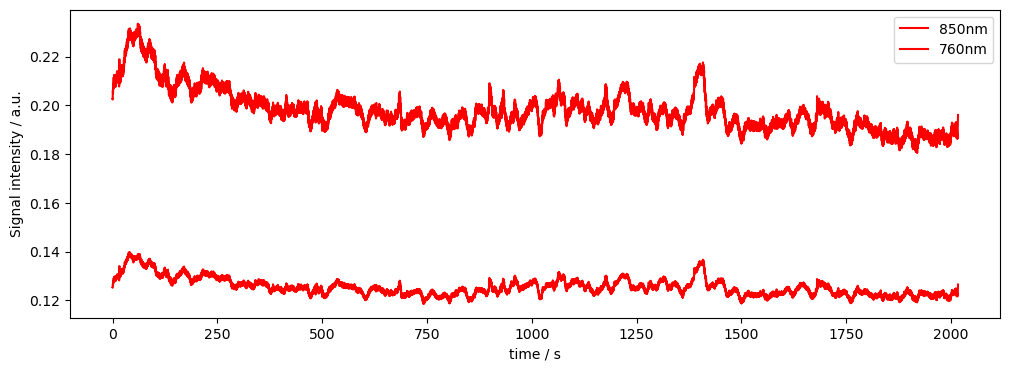

In [2]:
# get example finger tapping dataset

rec = datasets.get_fingertappingDOT()
rec["od"] = cedalion.nirs.int2od(rec["amp"])

# Plot some data for visual validation
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S1D4", wavelength="850"), "r-", label="850nm")
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S1D4", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

display(rec["amp"])

## Calculating Signal Quality Metrics and applying Masks

To assess channel quality metrics such as SNR, channel distances, average amplitudes, sci, and others, we use small helper functions. 
As input, the quality functions should also expect thresholds for these metrics, so they can feed back both the calculated quality metrics as well as a mask. The masks can then be combined and applied - e.g. to prune channels with low SNR.
The input and output arguments are based on xarray time series, quality parameters / instructions for thresholding. 
The returned mask is a boolean array in the shape and size of the input time series. It indicates where the threshold for our quality metric was passed ("True") and is False otherwise.
Masks can be combined with other masks, for instance to apply several metrics to assess or prune channels. At any point in time, the mask can be applied using the "apply_mask()" function available from cedalion's the xrutils package. 

If you are a user who is mainly interested in high-level application, you can skip to the Section "***Channel Pruning using Quality Metrics and the Pruning Function***" below. The "prune_ch()" function provides a higher abstraction layer to simply prune your data, using the same metrics and functions that are demonstrated below. 
 

### Channel Quality Metrics: SNR

In [3]:
# Here we assess channel quality by SNR
snr_thresh = 16 # the SNR (std/mean) of a channel. Set high here for demonstration purposes

# SNR thresholding using the "snr" function of the quality subpackage
snr, snr_mask = quality.snr(rec["amp"], snr_thresh)

# apply mask function. In this example, we want all signals with an SNR below the threshold to be replaced with "nan". 
# We do not want to collapse / combine any dimension of the mask (last argument: "none")
data_masked_snr_1, masked_elements_1 = xrutils.apply_mask(rec["amp"], snr_mask, "nan", "none")

# alternatively, we can "drop" all channels with an SNR below the threshold. Since the SNR of both wavelength might differ
# (pass the threshold for one wavelength, but not for the other), we collapse to the "channel" dimension.
data_masked_snr_2, masked_elements_2 = xrutils.apply_mask(rec["amp"], snr_mask, "drop", "channel")

# show some results
print(f"channels that were masked according to the SNR threshold: {masked_elements_2}")

# dropped:
data_masked_snr_2

mask collapsed to channel dimension
channels that were masked according to the SNR threshold: []


Magnitude,[[[0.08740092 0.08734962 0.08818625000000001 ... 0.09035587 0.09098898999999999 0.09272738] [0.13985697 0.13982265 0.14141524 ... 0.13390421 0.13521901 0.13864038]] [[0.27071937 0.27030255000000003 0.27172273 ... 0.26408907 0.26584981 0.26889485] [0.6563621900000001 0.6545556600000001 0.6593007200000001 ... 0.6250868700000001 0.6312341100000001 0.6415049700000001]] [[0.12522511 0.12516870000000002 0.12585573 ... 0.12442539999999999 0.1247638 0.12649158] [0.20260527 0.20239829999999998 0.20387636999999997 ... 0.19096156 0.19242489 0.19605341999999998]] ... [[0.12742799 0.12771832 0.12856141999999998 ... 0.12475135000000001 0.12405440000000001 0.1230771] [0.28363299 0.28471081 0.2877631 ... 0.26401557999999997 0.26345736 0.26146421999999997]] [[0.03967372 0.03983601 0.04008131 ... 0.03961476 0.039324559999999995 0.03901398] [0.1705261 0.17133473 0.17316590999999998 ... 0.16186235999999998 0.16202993999999998 0.16063382999999998]] [[0.08932346 0.08954745 0.0901911 ... 0.08869942 0.08842190999999999 0.08802665] [0.09587179 0.09623634 0.09746927999999999 ... 0.09036516 0.09042744999999999 0.08998772]]]
Units,volt


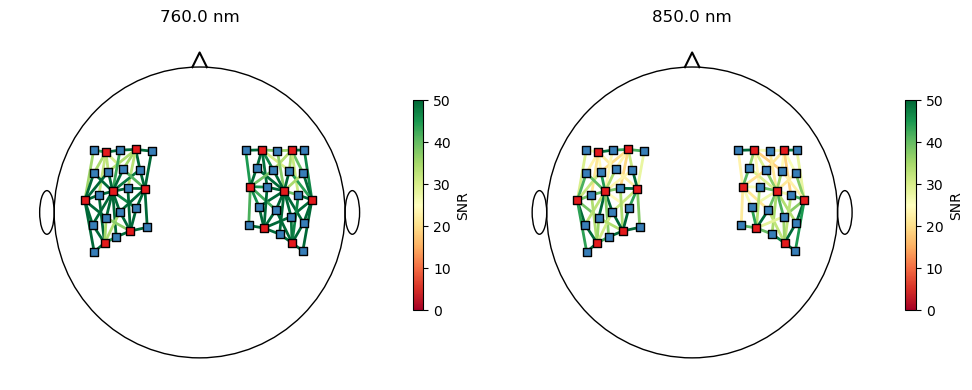

In [4]:
# we can plot the values per channel in a 2D montage
f, ax = p.subplots(1, 2, figsize=(10, 4))
for i, wl in enumerate(rec["amp"].wavelength.values):
    plots.scalp_plot(
        rec["amp"],
        rec.geo3d,
        snr.sel(wavelength=wl),
        ax[i],
        cmap="RdYlGn",
        vmin=0,
        vmax=50,
        title=f"{wl} nm",
        cb_label="SNR",
        channel_lw=2
    )
f.tight_layout()

### Channel Quality Metrics: Scalp Coupling Index

In [5]:
# Here we can assess the scalp coupling index (SCI) of the channels
sci_threshold = 0.75
window_length = 5*units.s
sci, sci_mask = quality.sci(rec["amp"], window_length, sci_threshold)

/opt/miniconda3/envs/cedalion_240902/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


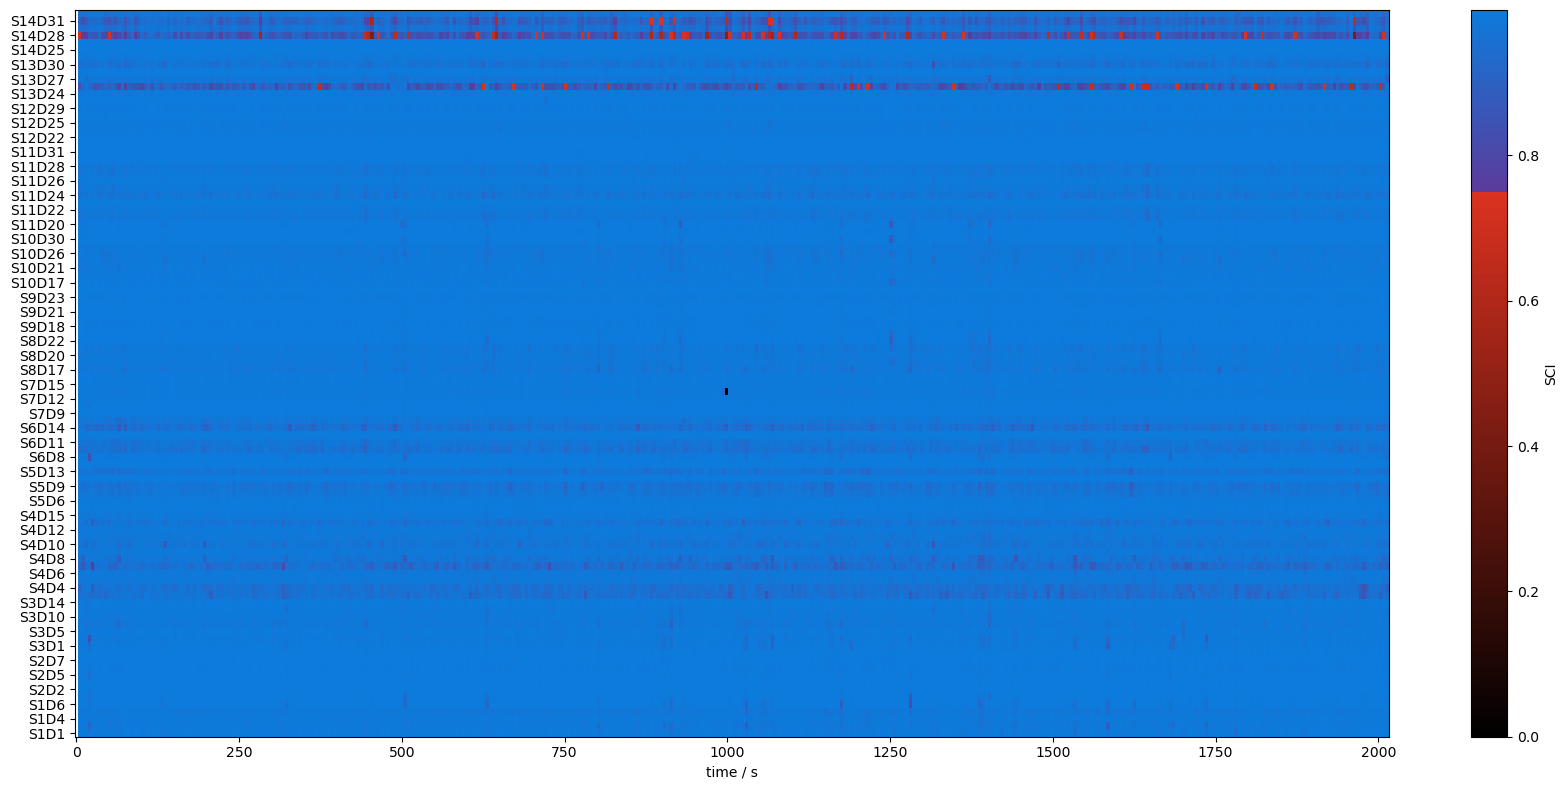

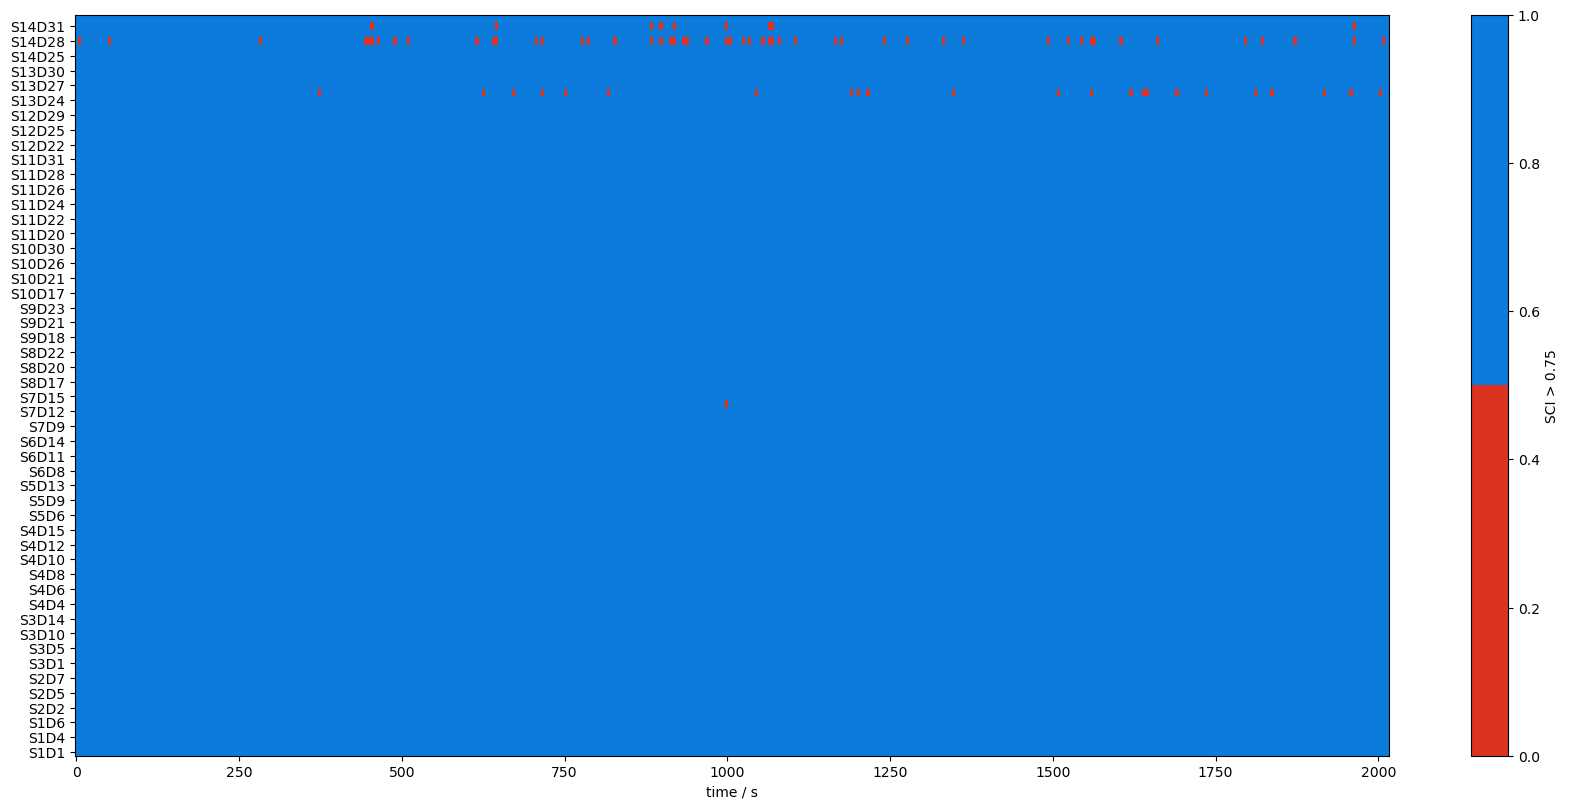

In [6]:
# we can plot a heat map to visualize the SCI across all time windows and channels
colors = ["black", "#DC3220", "#5D3A9B", "#0C7BDC"]
nodes = [0.0, 0.75, 0.751, 1.0]
sci_cmap = LinearSegmentedColormap.from_list("sci_cmap", list(zip(nodes,colors)))
sci_binary_cmap = LinearSegmentedColormap.from_list("sci_binary_cmap", list(zip([0,0.5,0.5,1],["#DC3220","#DC3220","#0C7BDC","#0C7BDC"])))

# plot the heatmap
f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(sci.time, np.arange(len(sci.channel)), sci, shading="nearest", cmap=sci_cmap, vmin=0)
cb = p.colorbar(m, ax=ax)
cb.set_label("SCI")
ax.set_xlabel("time / s")
p.tight_layout()
ax.yaxis.set_ticks(np.arange(0,sci.sizes["channel"], 2))
ax.yaxis.set_ticklabels(sci.channel.values[::2]);

# plot the binary heatmap
f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(sci.time, np.arange(len(sci.channel)), sci>0.75, shading="nearest", cmap=sci_binary_cmap)
cb = p.colorbar(m, ax=ax)
p.tight_layout()
ax.yaxis.set_ticks(np.arange(0,sci.sizes["channel"], 2))
ax.yaxis.set_ticklabels(sci.channel.values[::2]);
cb.set_label("SCI > 0.75")
ax.set_xlabel("time / s");

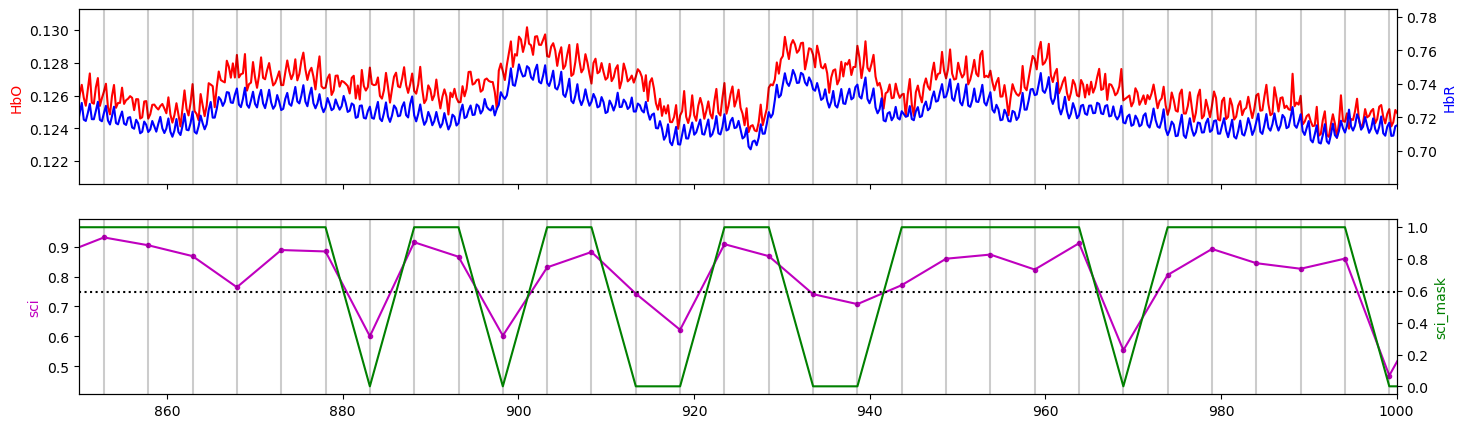

In [7]:
ch = "S14D28"
t1,t2 = 850, 1000
f,ax = p.subplots(2,1, figsize=(17,5), sharex=True)
ax[0].plot(rec["amp"].time, rec["amp"].sel(channel=ch, wavelength=760), "r-")
ax[0].set_ylabel("HbO", color="r")
ax02 = ax[0].twinx()
ax02.plot(rec["amp"].time, rec["amp"].sel(channel=ch, wavelength=850), "b-")
ax02.set_ylabel("HbR", color="b")
ax[1].plot(sci.time, sci.sel(channel=ch), "m.-")
ax[1].set_ylabel("sci", color="m")
ax12 = ax[1].twinx()
ax12.plot(sci_mask.time, sci_mask.sel(channel=ch), "g-")
ax12.set_ylabel("sci_mask", color="g")
ax[1].set_xlim(t1, t2)
ax[1].axhline(0.75, c="k", ls=":")
for i in sci.time.values:
    if i < t1 or i > t2:
        continue
    ax[0].axvline(i, c="k", alpha=.2)
    ax[1].axvline(i, c="k", alpha=.2)

### Channel Quality Metrics: Peak Spectral Power

In [8]:
# We can also look at the peak spectral power which takes the peak power of the cross-correlation signal between the cardiac band of the two wavelengths
psp_threshold = 0.1
psp, psp_mask = quality.psp(rec["amp"], window_length, psp_threshold)

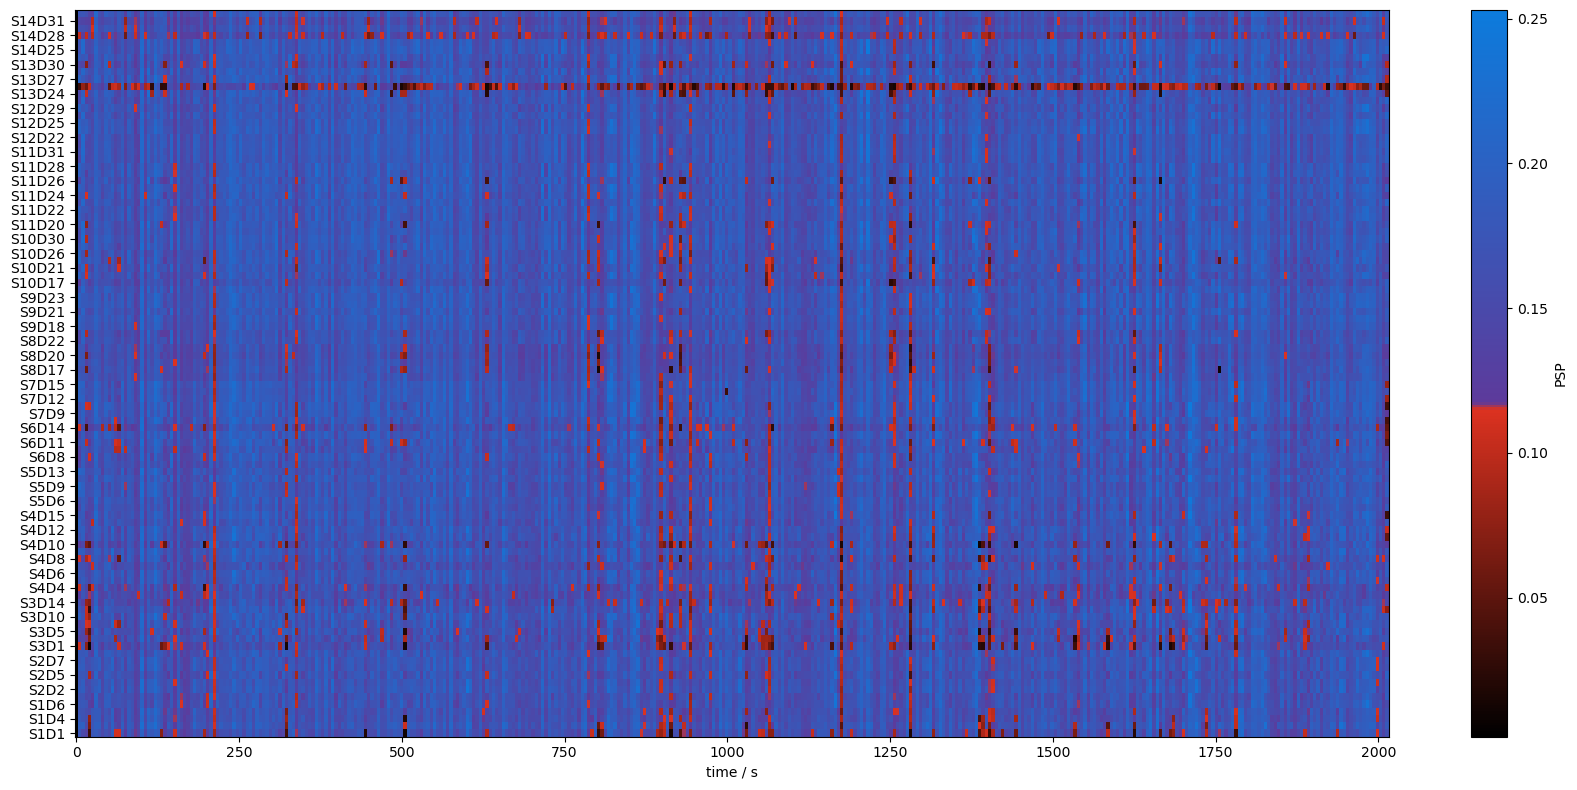

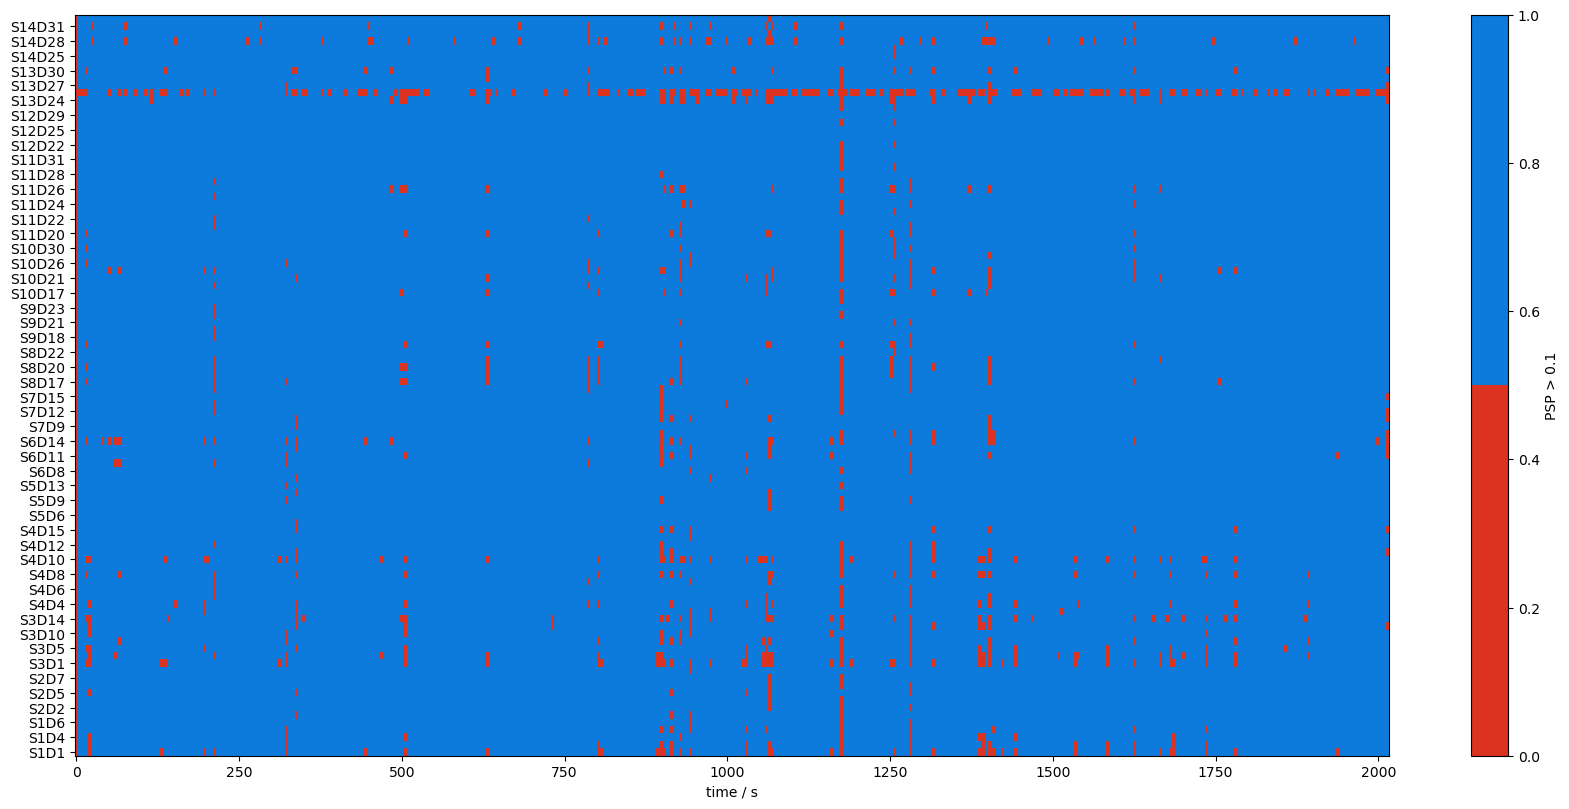

In [9]:
# We can look at similar heatmaps across time and channels
# plot the heatmap
colors = ["black", "#DC3220", "#5D3A9B", "#0C7BDC"]
nodes = [0.0, 0.45, 0.46, 1.0]
psp_cmap = LinearSegmentedColormap.from_list("psp_cmap", list(zip(nodes,colors)))
psp_binary_cmap = LinearSegmentedColormap.from_list("psp_binary_cmap", list(zip([0,0.5,0.5,1],["#DC3220","#DC3220","#0C7BDC","#0C7BDC"])))

f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(psp.time, np.arange(len(psp.channel)), psp, shading="nearest", cmap=psp_cmap)
cb = p.colorbar(m, ax=ax)
cb.set_label("PSP")
ax.set_xlabel("time / s")
p.tight_layout()
ax.yaxis.set_ticks(np.arange(0,psp.sizes["channel"], 2))
ax.yaxis.set_ticklabels(psp.channel.values[::2]);

# plot the binary heatmap
f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(psp.time, np.arange(len(psp.channel)), psp>psp_threshold, shading="nearest", cmap=psp_binary_cmap)
cb = p.colorbar(m, ax=ax)
p.tight_layout()
ax.yaxis.set_ticks(np.arange(0,psp.sizes["channel"], 2))
ax.yaxis.set_ticklabels(psp.channel.values[::2]);
cb.set_label("PSP > 0.1")
ax.set_xlabel("time / s");

### Combining SCI and PSP
We want both SCI and PSP to be above their respective thresholds for a window to be considered clean. We can then look at the percentage of time both metrics are above the thresholds.

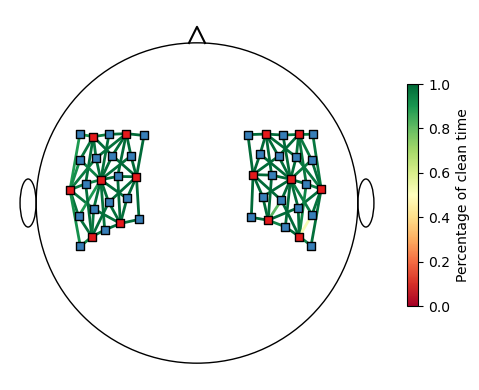

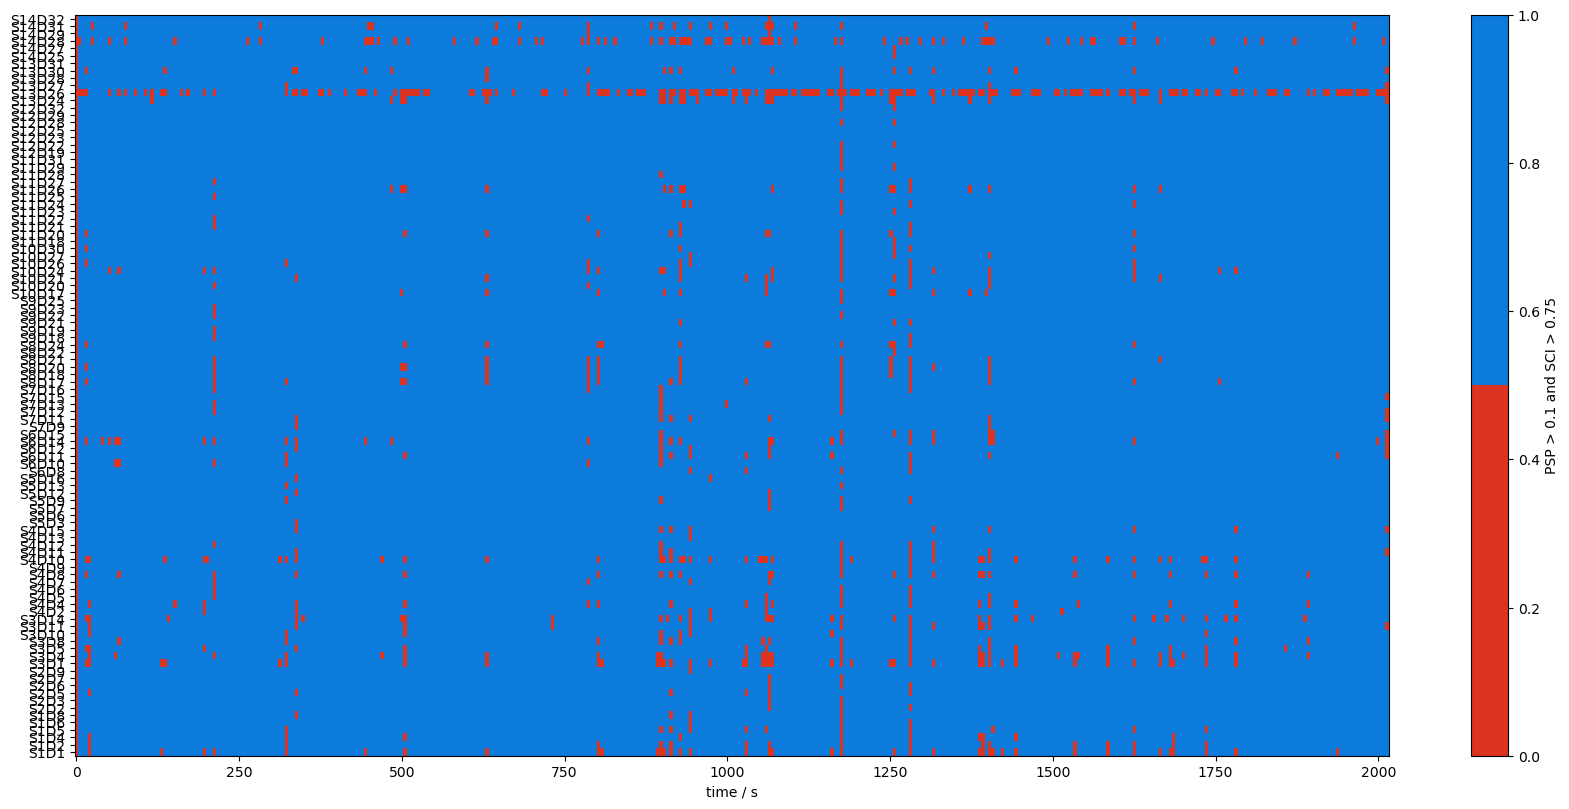

In [15]:
sci_x_psp_mask = sci_mask & psp_mask
perc_time_clean = sci_x_psp_mask.sum(dim="time") / len(sci.time)

# plot the percentage of clean time per channel
f, ax = p.subplots(1, 1, figsize=(5, 4))

plots.scalp_plot(
    rec["amp"],
    rec.geo3d,
    perc_time_clean,
    ax,
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    title=None,
    cb_label="Percentage of clean time",
    channel_lw=2
)
f.tight_layout()





# we can also plot this as a binary heatmap
f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(sci_x_psp_mask.time, np.arange(len(sci_x_psp_mask.channel)), sci_x_psp_mask, shading="nearest", cmap=sci_binary_cmap)
cb = p.colorbar(m, ax=ax)
p.tight_layout()
ax.yaxis.set_ticks(np.arange(len(sci_x_psp_mask.channel)))
ax.yaxis.set_ticklabels(sci_x_psp_mask.channel.values);
cb.set_label("PSP > 0.1 and SCI > 0.75")
ax.set_xlabel("time / s");

### Channel Quality Metrics: Channel Distance

In [11]:
# Here we assess channel distances. We might want to exclude very short or very long channels
sd_threshs = [1, 4.5]*units.cm # defines the lower and upper bounds for the source-detector separation that we would like to keep

# Source Detector Separation thresholding
ch_dist, sd_mask = quality.sd_dist(rec["amp"], rec.geo3d, sd_threshs)
# print the channel distances
print(f"channel distances are: {ch_dist}")

# apply mask function. In this example, we want to "drop" all channels that do not fall inside sd_threshs 
# i.e. drop channels shorter than 1cm and longer than 4.5cm. We want to collapse along the "channel" dimension.
data_masked_sd, masked_elements = xrutils.apply_mask(rec["amp"], sd_mask, "drop", "channel")

# display the resultings
print(f"channels that were masked according to the SD Distance thresholds: {masked_elements}")
data_masked_sd

channel distances are: <xarray.DataArray (channel: 100)> Size: 800B
<Quantity([19.403 18.434 17.182 18.147 32.15  30.175 19.178 19.447 32.539 19.148
 20.387 32.401 31.84  18.5   33.442 20.507 19.478 35.139 33.078 31.985
 33.856 18.139 18.801 33.619 18.863 18.957 35.02  20.168 19.826 34.426
 34.345 32.88  33.723 18.521 20.207 33.336 18.213 32.877 33.672 19.431
 19.052 33.567 19.195 18.425 34.355 32.674 19.812 19.848 19.528 20.949
 19.251 19.39  18.551 19.024 34.549 32.646 18.709 19.515 32.9   19.18
 19.4   31.861 32.587 18.438 32.845 19.721 19.604 33.946 33.34  31.912
 33.631 19.296 18.898 34.598 19.469 20.848 34.332 20.36  19.642 34.906
 33.393 32.419 33.181 18.976 19.684 34.214 18.971 33.127 33.994 19.443
 19.768 35.401 19.298 20.288 33.599 35.398 20.304 18.596 20.823 18.585], 'millimeter')>
Coordinates:
  * channel   (channel) object 800B 'S1D1' 'S1D2' 'S1D4' ... 'S14D31' 'S14D32'
    source    (channel) object 800B 'S1' 'S1' 'S1' 'S1' ... 'S14' 'S14' 'S14'
    detector  (channel) ob

Magnitude,[[[0.08740092 0.08734962 0.08818625000000001 ... 0.09035587 0.09098898999999999 0.09272738] [0.13985697 0.13982265 0.14141524 ... 0.13390421 0.13521901 0.13864038]] [[0.27071937 0.27030255000000003 0.27172273 ... 0.26408907 0.26584981 0.26889485] [0.6563621900000001 0.6545556600000001 0.6593007200000001 ... 0.6250868700000001 0.6312341100000001 0.6415049700000001]] [[0.12522511 0.12516870000000002 0.12585573 ... 0.12442539999999999 0.1247638 0.12649158] [0.20260527 0.20239829999999998 0.20387636999999997 ... 0.19096156 0.19242489 0.19605341999999998]] ... [[0.12742799 0.12771832 0.12856141999999998 ... 0.12475135000000001 0.12405440000000001 0.1230771] [0.28363299 0.28471081 0.2877631 ... 0.26401557999999997 0.26345736 0.26146421999999997]] [[0.03967372 0.03983601 0.04008131 ... 0.03961476 0.039324559999999995 0.03901398] [0.1705261 0.17133473 0.17316590999999998 ... 0.16186235999999998 0.16202993999999998 0.16063382999999998]] [[0.08932346 0.08954745 0.0901911 ... 0.08869942 0.08842190999999999 0.08802665] [0.09587179 0.09623634 0.09746927999999999 ... 0.09036516 0.09042744999999999 0.08998772]]]
Units,volt


### Channel Quality Metrics: Mean Amplitudes

In [12]:
# Here we assess average channel amplitudes. We might want to exclude very small or large signals
amp_threshs = [0.1, 3]*units.volt # define whether a channel's amplitude is within a certain range

# Amplitude thresholding
mean_amp, amp_mask = quality.mean_amp(rec["amp"], amp_threshs)

# apply mask function. In this example, we want drop all channels that do not fall inside the amplitude thresholds. 
# We collapse to the "channel" dimension.
data_masked_amp, masked_elements = xrutils.apply_mask(rec["amp"], amp_mask, "drop", "channel")

# display the results
print(f"channels that were masked according to the amplitude threshold: {masked_elements}")
data_masked_amp


mask collapsed to channel dimension
channels that were masked according to the amplitude threshold: ['S1D1' 'S1D5' 'S4D2' 'S4D4' 'S4D7' 'S4D9' 'S4D10' 'S4D13' 'S4D15' 'S5D6'
 'S5D9' 'S6D10' 'S6D11' 'S6D14' 'S8D20' 'S8D21' 'S9D23' 'S10D17' 'S10D21'
 'S10D27' 'S11D24' 'S12D22' 'S12D25' 'S14D31' 'S14D32']


Magnitude,[[[0.27071937 0.27030255000000003 0.27172273 ... 0.26408907 0.26584981 0.26889485] [0.6563621900000001 0.6545556600000001 0.6593007200000001 ... 0.6250868700000001 0.6312341100000001 0.6415049700000001]] [[0.12522511 0.12516870000000002 0.12585573 ... 0.12442539999999999 0.1247638 0.12649158] [0.20260527 0.20239829999999998 0.20387636999999997 ... 0.19096156 0.19242489 0.19605341999999998]] [[0.32947141999999996 0.33049359 0.33316944000000004 ... 0.32432194999999997 0.3266376 0.32564217] [0.60771636 0.61035002 0.61705844 ... 0.58318041 0.5881105600000001 0.58641498]] ... [[0.18055411999999998 0.18162612 0.18316672 ... 0.17533628999999998 0.17535009999999998 0.17346171] [0.29276165 0.29519715 0.29914887 ... 0.26974594 0.27166716 0.26730504]] [[0.12703694 0.12716247 0.12791476000000002 ... 0.12485857 0.12423857999999999 0.12365873999999999] [0.7466864400000001 0.74893494 0.7551256000000001 ... 0.7063701099999999 0.7077436699999999 0.70682367]] [[0.12742799 0.12771832 0.12856141999999998 ... 0.12475135000000001 0.12405440000000001 0.1230771] [0.28363299 0.28471081 0.2877631 ... 0.26401557999999997 0.26345736 0.26146421999999997]]]
Units,volt


### Channel Pruning using Quality Metrics and the Pruning Function

To prune channels according to quality criteria, we do not have to manually go through the steps above. Instead, we can create quality masks for the metrics that we are interested in and hand them to a dedicated channel pruning function. The prune function expects a list of quality masks alongside a logical operator that defines how these masks should be combined.

In [13]:
# as above we use three metrics and define thresholds accordingly
snr_thresh = 16 # the SNR (std/mean) of a channel. 
sd_threshs = [1, 4.5]*units.cm # defines the lower and upper bounds for the source-detector separation that we would like to keep
amp_threshs = [0.1, 3]*units.volt # define whether a channel's amplitude is within a certain range

# then we calculate the masks for each metric: SNR, SD distance and mean amplitude
_, snr_mask = quality.snr(rec["amp"], snr_thresh)
_, sd_mask = quality.sd_dist(rec["amp"], rec.geo3d, sd_threshs)
_, amp_mask = quality.mean_amp(rec["amp"], amp_threshs)
# you can also include other masks, e.g. the SCI mask

# put all masks in a list
masks = [snr_mask, sd_mask, amp_mask]

# prune channels using the masks and the operator "all", which will keep only channels that pass all three metrics
amp_pruned, drop_list = quality.prune_ch(rec["amp"], masks, "all")

# print list of dropped channels
print(f"List of pruned channels: {drop_list}")
# display the new data xarray
amp_pruned

mask collapsed to channel dimension
List of pruned channels: ['S1D1' 'S1D5' 'S4D2' 'S4D4' 'S4D7' 'S4D9' 'S4D10' 'S4D13' 'S4D15' 'S5D6'
 'S5D9' 'S6D10' 'S6D11' 'S6D14' 'S8D20' 'S8D21' 'S9D23' 'S10D17' 'S10D21'
 'S10D27' 'S11D24' 'S12D22' 'S12D25' 'S14D31' 'S14D32']


Magnitude,[[[0.27071937 0.27030255000000003 0.27172273 ... 0.26408907 0.26584981 0.26889485] [0.6563621900000001 0.6545556600000001 0.6593007200000001 ... 0.6250868700000001 0.6312341100000001 0.6415049700000001]] [[0.12522511 0.12516870000000002 0.12585573 ... 0.12442539999999999 0.1247638 0.12649158] [0.20260527 0.20239829999999998 0.20387636999999997 ... 0.19096156 0.19242489 0.19605341999999998]] [[0.32947141999999996 0.33049359 0.33316944000000004 ... 0.32432194999999997 0.3266376 0.32564217] [0.60771636 0.61035002 0.61705844 ... 0.58318041 0.5881105600000001 0.58641498]] ... [[0.18055411999999998 0.18162612 0.18316672 ... 0.17533628999999998 0.17535009999999998 0.17346171] [0.29276165 0.29519715 0.29914887 ... 0.26974594 0.27166716 0.26730504]] [[0.12703694 0.12716247 0.12791476000000002 ... 0.12485857 0.12423857999999999 0.12365873999999999] [0.7466864400000001 0.74893494 0.7551256000000001 ... 0.7063701099999999 0.7077436699999999 0.70682367]] [[0.12742799 0.12771832 0.12856141999999998 ... 0.12475135000000001 0.12405440000000001 0.1230771] [0.28363299 0.28471081 0.2877631 ... 0.26401557999999997 0.26345736 0.26146421999999997]]]
Units,volt


### Timeseries Quality Metric: Global Variance of the Temporal Derivative

/opt/miniconda3/envs/cedalion_240902/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


(0.0, 500.0)

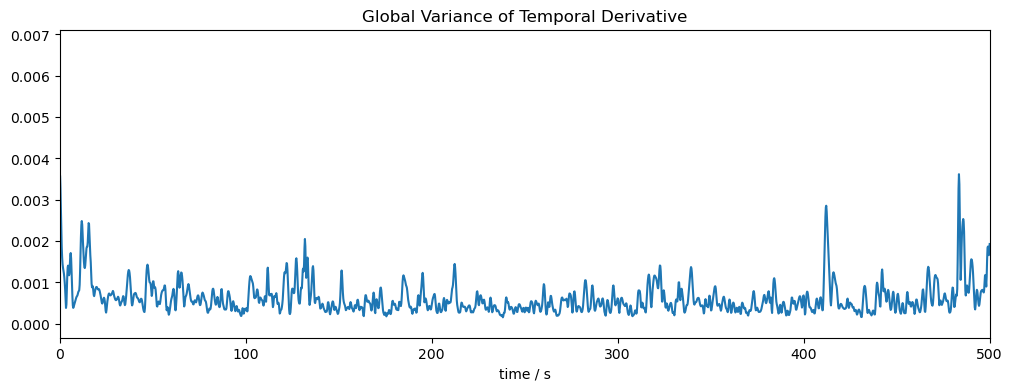

In [14]:
# we can plot the timeseries of the GVTD to evaluate motion in the data
gvtd = quality.gvtd(rec["amp"])
f, ax = p.subplots(1,1, figsize=(12,4))
ax.plot(gvtd.time, gvtd)
ax.set_xlabel("time / s")
ax.set_title("Global Variance of Temporal Derivative")
ax.set_xlim(0, 500)